Goal is to develop a data-driven credit risk model in Python to predict the probabilities of default (PD) and assign credit scores to existing or potential borrowers based on the lending club loan data from 2007 to 2014. We will determine credit scores using a highly interpretable, easy to understand and implement scorecard that makes calculating the credit score a breeze.

## Environment Setup

In [1]:
# Import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency

## Import Data

In [3]:
loan_data = pd.read_csv(r'D:\2.1_codebase\0_Data\Datasets\loan_data_2007_2014.csv')

C:\Users\tharu\AppData\Local\Temp\ipykernel_4604\3932263739.py:1: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_data = pd.read_csv(r'D:\2.1_codebase\0_Data\Datasets\loan_data_2007_2014.csv')


## Data Exploration

In [7]:
# Setting the maximum display columns for pandas to 'None' 
# so it displays ALL columns in the dataframe without truncation
pd.options.display.max_columns = None
loan_data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [8]:

# Calculate the fraction of missing values (NaN) for each column in the 'loan_data' dataframe
na_values = loan_data.isnull().mean()

# Filter the columns where the fraction of missing values is greater than 0.8 (or 80%)
# This will return a series of columns with their respective fraction of missing values
na_values[na_values > 0.8]


mths_since_last_record       0.865666
annual_inc_joint             1.000000
dti_joint                    1.000000
verification_status_joint    1.000000
open_acc_6m                  1.000000
open_il_6m                   1.000000
open_il_12m                  1.000000
open_il_24m                  1.000000
mths_since_rcnt_il           1.000000
total_bal_il                 1.000000
il_util                      1.000000
open_rv_12m                  1.000000
open_rv_24m                  1.000000
max_bal_bc                   1.000000
all_util                     1.000000
inq_fi                       1.000000
total_cu_tl                  1.000000
inq_last_12m                 1.000000
dtype: float64

In [9]:
# drop columns with more than 80% null values
required_non_na = loan_data.shape[0] * 0.2
loan_data.dropna(axis=1, thresh=required_non_na, inplace=True)

'''
drop redundant and forward-looking columns
redundant like id, member_id, title, etc.
forward-looking like recoveries, collection_recovery_fee, etc.
drop sub_grade as same information is captured in grade column
drop next_pymnt_d since, given that our data is historical and this column is supposed to have future dates, will not make sense for our model
'''
loan_data.drop(columns = ['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'title', 'zip_code', 'next_pymnt_d',
                          'recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_late_fee'], inplace = True)

In [10]:
# Re-explore the df
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    466285 non-null  int64  
 1   funded_amnt                  466285 non-null  int64  
 2   funded_amnt_inv              466285 non-null  float64
 3   term                         466285 non-null  object 
 4   int_rate                     466285 non-null  float64
 5   installment                  466285 non-null  float64
 6   grade                        466285 non-null  object 
 7   emp_length                   445277 non-null  object 
 8   home_ownership               466285 non-null  object 
 9   annual_inc                   466281 non-null  float64
 10  verification_status          466285 non-null  object 
 11  issue_d                      466285 non-null  object 
 12  loan_status                  466285 non-null  object 
 13 

## Identify the target variable

In [11]:
# explore the unique values in loan_status column
loan_data['loan_status'].value_counts(normalize = True)
#normalize=True: By setting this parameter, the method will return the relative frequencies 
# (as a proportion of the total) of each unique value, 
# rather than their absolute counts. So if the dataset has 1000 loans, and 700 of them have 
# a loan status of "Fully Paid", the output for "Fully Paid" would be 0.7.

loan_status
Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: proportion, dtype: float64

In [27]:
# create a new column based on the loan_status column that will be our target variable
loan_data['good_bad'] = np.where(loan_data.loc[:, 'loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)',
                                                                       'Does not meet the credit policy. Status:Charged Off']), 0, 1)
# Drop the original 'loan_status' column
loan_data.drop(columns = ['loan_status'], inplace = True)

## Split data

In [28]:
# split data into 80/20 while keeping the distribution of bad loans in test set same as that in the pre-split dataset
X = loan_data.drop('good_bad', axis = 1)
y = loan_data['good_bad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# specifically hard copying the training sets to avoid Pandas' SetttingWithCopyWarning when we play around with this data later on.
# as noted [here](https://github.com/scikit-learn/scikit-learn/issues/8723), this is currently an open issue between Pandas and Scikit-Learn teams
X_train, X_test = X_train.copy(), X_test.copy()

## General data cleaning

**emp_length**

In [30]:
print(X_train[X_train['emp_length'] == '10+'])

        loan_amnt  funded_amnt  funded_amnt_inv        term  int_rate  \
451541       8000         8000           8000.0   60 months     18.25   
139343      15825        15825          15825.0   36 months     12.12   
462741      18725        18725          18725.0   36 months     14.98   
72091       17475        17475          17475.0   36 months     19.20   
408601      30000        30000          30000.0   60 months     16.59   
...           ...          ...              ...         ...       ...   
450451      12800        12800          12750.0   60 months     13.98   
406312      28100        28100          28075.0   60 months     22.45   
193028      20800        20800          20800.0   36 months     14.09   
152674      12000        12000          12000.0   36 months     14.33   
163633      22800        22800          22800.0   60 months     16.29   

        installment grade emp_length home_ownership  annual_inc  \
451541       204.24     D        10+            OWN     

In [42]:
loan_data['emp_length'] = loan_data['emp_length'].str.replace('10\+', '10')
loan_data['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [43]:
loan_data['emp_length'] = loan_data['emp_length'].str.replace('10+ years', '10')


In [51]:
print(loan_data['emp_length'].unique())

[10.  0.  1.  3.  8.  9.  4.  5.  6.  2.  7. nan]


def emp_length_converter(df, column):
    # Replacing '< 1 year' with '0'
    df[column] = df[column].str.replace('< 1 year', '0')
    
    # Replacing '10+ years' with '10'
    df[column] = df[column].str.replace('10\+ years', '10')
    
    # Removing ' years' and ' year' from the string
    df[column] = df[column].str.replace(' years', '').str.replace(' year', '')
    
    # Converting column to numeric
    df[column] = pd.to_numeric(df[column], errors='coerce')
    
    # Filling NaN values with 0
    df[column].fillna(value=0, inplace=True)

# Usage:
emp_length_converter(loan_data, 'emp_length')

print(X_train['emp_length'].unique())


**date columns**

In [52]:
# convert date columns to datetime format and create a new column as a difference between today and the respective date
def date_columns(df, column):
    # store current month
    today_date = pd.to_datetime('2023-08-01')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)

# apply to X_train
date_columns(X_train, 'earliest_cr_line')
date_columns(X_train, 'issue_d')
date_columns(X_train, 'last_pymnt_d')
date_columns(X_train, 'last_credit_pull_d')

# let's check these new columns
print(X_train['mths_since_earliest_cr_line'].describe())
print(X_train['mths_since_issue_d'].describe())
print(X_train['mths_since_last_pymnt_d'].describe())
print(X_train['mths_since_last_credit_pull_d'].describe())

count    373003.000000
mean        269.331056
std          84.805903
min         103.000000
25%         211.000000
50%         252.000000
75%         311.000000
max         608.000000
Name: mths_since_earliest_cr_line, dtype: float64
count    373028.000000
mean         81.844250
std          13.938665
min          67.000000
25%          72.000000
50%          78.000000
75%          87.000000
max         155.000000
Name: mths_since_issue_d, dtype: float64
count    372717.000000
mean         62.203594
std          12.578076
min          54.000000
25%          54.000000
50%          55.000000
75%          66.000000
max         149.000000
Name: mths_since_last_pymnt_d, dtype: float64
count    372998.000000
mean         58.002796
std           9.477184
min          54.000000
25%          54.000000
50%          54.000000
75%          56.000000
max         156.000000
Name: mths_since_last_credit_pull_d, dtype: float64


**term**

In [53]:
# function to remove 'months' string from the 'term' column and convert it to numeric
def loan_term_converter(df, column):
    df[column] = pd.to_numeric(df[column].str.replace(' months', ''))

loan_term_converter(X_train, 'term')

## Feature Selection

In [54]:
# first divide training data into categorical and numerical subsets
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

**Chi-squared statistic for categorical features**

In [55]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,grade,0.000000
1,emp_length,0.000000
2,home_ownership,0.000000
3,verification_status,0.000000
4,purpose,0.000000
5,addr_state,0.000000
6,initial_list_status,0.000000
7,pymnt_plan,0.000923
8,application_type,1.000000


Let's keep only the top four categorical features

**ANOVA F-Statistic for numerical features**

In [56]:
# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
X_train_num.fillna(X_train_num.mean(), inplace = True)
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num, y_train)
# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

C:\Users\tharu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\tharu\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


,Numerical_Feature,F-Score,p values
0,mths_since_last_pymnt_d,23821.725199,0.000000e+00
1,total_pymnt_inv,14784.534040,0.000000e+00
2,total_pymnt,14686.729567,0.000000e+00
3,int_rate,11462.788313,0.000000e+00
4,last_pymnt_amnt,10826.949727,0.000000e+00
5,out_prncp,9635.116160,0.000000e+00
6,out_prncp_inv,9633.442129,0.000000e+00
7,mths_since_last_credit_pull_d,7111.845174,0.000000e+00
8,mths_since_issue_d,2766.569198,0.000000e+00
9,inq_last_6mths,2003.820465,0.000000e+00


For the sake of simplicity, we will keep only the top 20 features and calculate pair-wise correlations between them

**Pair wise correlations to detect multicollinearity**

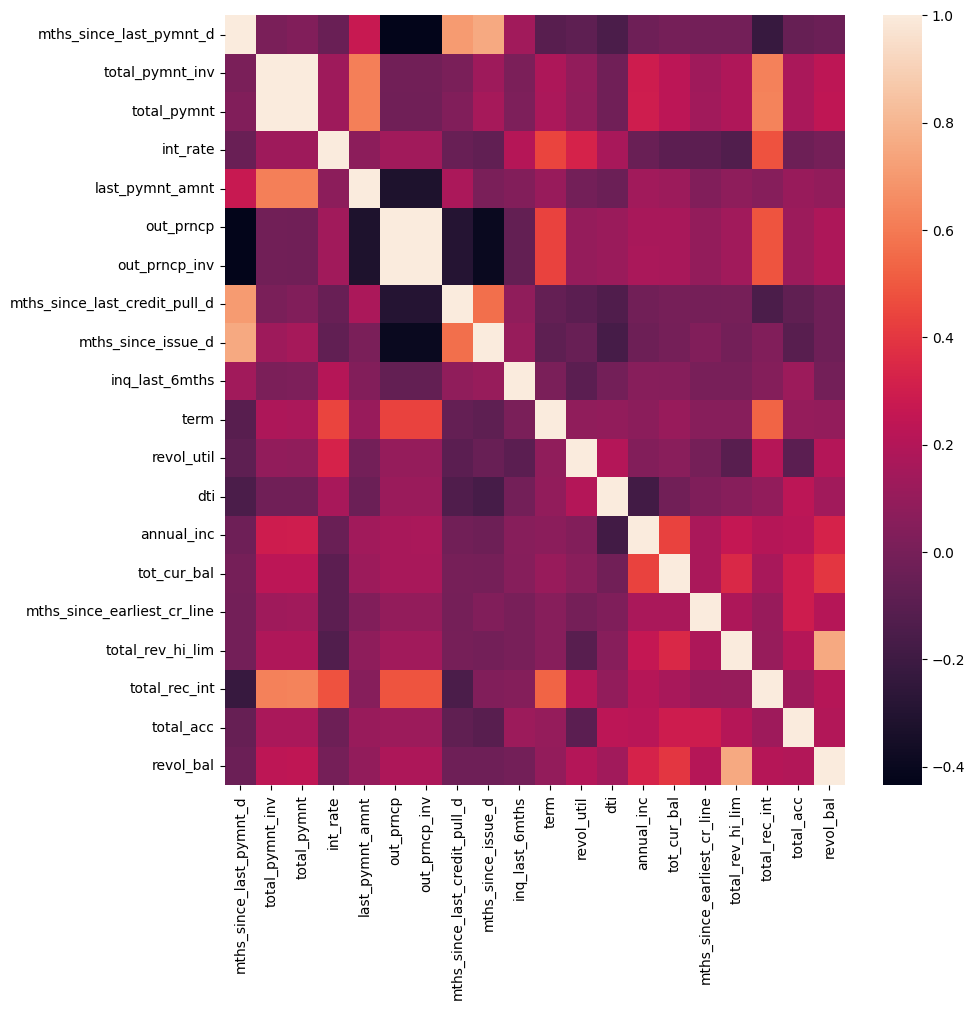

In [57]:
# save the top 20 numerical features in a list
top_num_features = ANOVA_F_table.iloc[:20,0].to_list()
# calculate pair-wise correlations between them
corrmat = X_train_num[top_num_features].corr()
plt.figure(figsize=(10,10))
sns.heatmap(corrmat);

The following features can also be safely dropped given their multicollinearity with other features:
- out_prncp_inv
- total_pymnt_inv

In [58]:
# Define a helper function to drop the 4 categorical features with least p-values for chi squared test, 14 numerical features with least F-Statistic
# and 2 numerical features with high multicollinearity
drop_columns_list = ANOVA_F_table.iloc[20:, 0].to_list()
drop_columns_list.extend(chi2_result.iloc[4:, 0].to_list())
drop_columns_list.extend(['out_prncp_inv', 'total_pymnt_inv'])

def col_to_drop(df, columns_list):
    df.drop(columns = columns_list, inplace = True)

# apply to X_train
col_to_drop(X_train, drop_columns_list)


## Creating dummy variables
**Convet discrete variables to dummy variables**

In [59]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 373028 entries, 456615 to 38736
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   term                           373028 non-null  int64  
 1   int_rate                       373028 non-null  float64
 2   grade                          373028 non-null  object 
 3   emp_length                     356235 non-null  object 
 4   home_ownership                 373028 non-null  object 
 5   annual_inc                     373024 non-null  float64
 6   verification_status            373028 non-null  object 
 7   dti                            373028 non-null  float64
 8   inq_last_6mths                 373003 non-null  float64
 9   revol_bal                      373028 non-null  int64  
 10  revol_util                     372764 non-null  float64
 11  total_acc                      373003 non-null  float64
 12  out_prncp                      

In [62]:
# function to create dummy variables
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

# apply to our final four categorical variables
X_train = dummy_creation(X_train, ['grade', 'home_ownership', 'verification_status'])

In [61]:
print(X_train.columns)


Index(['term', 'int_rate', 'grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'dti', 'inq_last_6mths',
       'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'total_pymnt',
       'total_rec_int', 'last_pymnt_amnt', 'tot_cur_bal', 'total_rev_hi_lim',
       'mths_since_earliest_cr_line', 'mths_since_issue_d',
       'mths_since_last_pymnt_d', 'mths_since_last_credit_pull_d'],
      dtype='object')


## Update the test data set with all data cleaning procedures performed so far

In [65]:
emp_length_converter(X_test, 'emp_length')
date_columns(X_test, 'earliest_cr_line')
date_columns(X_test, 'issue_d')
date_columns(X_test, 'last_pymnt_d')
date_columns(X_test, 'last_credit_pull_d')
loan_term_converter(X_test, 'term')
col_to_drop(X_test, drop_columns_list)
X_test = dummy_creation(X_test, ['grade', 'home_ownership', 'verification_status'])
# reindex the dummied test set variables to make sure all the feature columns in the train set are also available in the test set
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

AttributeError: Can only use .str accessor with string values!

In [66]:
print(X_test['emp_length'].dtypes)

float64


In [67]:
X_test['emp_length'] = X_test['emp_length'].astype(str)

In [68]:
X_test['emp_length'] = X_test['emp_length'].fillna('Unknown')

In [69]:
emp_length_converter(X_test, 'emp_length')
date_columns(X_test, 'earliest_cr_line')
date_columns(X_test, 'issue_d')
date_columns(X_test, 'last_pymnt_d')
date_columns(X_test, 'last_credit_pull_d')
loan_term_converter(X_test, 'term')
col_to_drop(X_test, drop_columns_list)
X_test = dummy_creation(X_test, ['grade', 'home_ownership', 'verification_status'])
# reindex the dummied test set variables to make sure all the feature columns in the train set are also available in the test set
X_test = X_test.reindex(labels=X_train.columns, axis=1, fill_value=0)

KeyError: 'earliest_cr_line'

In [70]:
print('earliest_cr_line' in X_test.columns)

False
